In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [3]:
net = nn.Sequential(nn.Linear(20,256),
                    nn.ReLU(),
                    nn.Linear(256,10))
X=torch.rand(2,20)
net(X)

tensor([[-0.2488, -0.3145,  0.0008,  0.0825,  0.0727, -0.0305, -0.0758, -0.2952,
          0.3673, -0.0616],
        [-0.4255, -0.3671, -0.1042,  0.1690, -0.0245,  0.0432, -0.1057, -0.0810,
          0.3890, -0.1861]], grad_fn=<AddmmBackward0>)

## 5.1.1 自定义块

In [5]:
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接层
    def __init__(self):
        # 继承、类、多态、对象
        # 调用MLP的父类Module的构造函数来执行必要的初始化
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params
        super().__init__()
        # 我们定制的__init__函数通过super().__init__()调用父类的__init__()函数
        # 好处：省去了重复编写模版代码的痛苦
        self.hidden = nn.Linear(20,256) #隐藏层
        self.out = nn.Linear(256,10) #输出层
        # 我们实例化两个全连接层，分别为self.hidden，self.out
        # 不用担心反向传播函数或者参数初始化，系统自动生成

    # 定义模型的前向传播，即如何根据输入x返回所需的模型输出
    def forward(self,X):
        # 使用ReLU函数，在nn.functional模块中定义
        return self.out(F.relu(self.hidden(X)))

In [6]:
net = MLP()
net(X)

tensor([[ 0.0357, -0.0524,  0.1999,  0.1278,  0.0977,  0.1056,  0.0623, -0.2163,
         -0.0364,  0.0312],
        [ 0.0872,  0.0292,  0.1294,  0.1365,  0.0866,  0.2760,  0.0097, -0.2367,
         -0.0411,  0.1338]], grad_fn=<AddmmBackward0>)

## 5.1.2顺序块

In [8]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx,module in enumerate(args):
            # 这里，module是Module子类的一个实例，我们把它保存在'Module'类的成员
            # 变量_modules中，_module的类型是OrderDict
            self._modules[str(idx)] = module
    def forward(self,X):
        # OrderedDcit保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

In [10]:
net = MySequential(nn.Linear(20,256),
                   nn.ReLU(),
                   nn.Linear(256,10))

net(X)

tensor([[ 0.1577,  0.0627, -0.1361,  0.0928, -0.0228, -0.0641, -0.2009,  0.0866,
          0.0290,  0.0266],
        [ 0.1293, -0.1212, -0.1421,  0.2559,  0.0570, -0.0442, -0.2728, -0.0027,
          0.2539,  0.0807]], grad_fn=<AddmmBackward0>)

In [13]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变
        self.rand_weight = torch.rand((20,20),requires_grad=False)
        self.linear = nn.Linear(20,20)
    def forward(self,X):
        X = self.linear(X)
        # 使用创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X,self.rand_weight)+1)
        # 复用全连接层，相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流
        while X.abs().sum() >1:
            X /= 2
        return X.sum()

In [14]:
net = FixedHiddenMLP()
net(X)

tensor(0.0649, grad_fn=<SumBackward0>)

In [15]:
# 混合搭配组合块
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20,64),
                                 nn.ReLU(),
                                 nn.Linear(64,32),
                                 nn.ReLU())
        self.linear = nn.Linear(32,16)
    def forward(self,X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(),
                        nn.Linear(16,20),
                        FixedHiddenMLP())
chimera(X)

tensor(0.0423, grad_fn=<SumBackward0>)

# 5.2参数管理 

In [16]:
import torch
from torch import nn

In [17]:
net = nn.Sequential(nn.Linear(4,8),
                    nn.ReLU(),
                    nn.Linear(8,1))
X = torch.rand(size=(2,4))
net(X)

tensor([[-0.0021],
        [ 0.0517]], grad_fn=<AddmmBackward0>)

In [18]:
# 参数访问
# 从已有模型中访问参数，通过Sequential类定义模型，通过索引访问模型的任意层
# 模型相当于列表 每层的参数都在其属性中
# eg.检查第二个全连接层的参数
print(net[2].state_dict())

OrderedDict([('weight', tensor([[ 0.2288,  0.2173, -0.2982,  0.3237,  0.2112, -0.2636,  0.0955,  0.3158]])), ('bias', tensor([-0.1891]))])


In [20]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>


In [21]:
net[2].weight.grad == None

True

In [23]:
# 一次性访问所有参数
print(*[(name,param.shape) for name,param in net[0].named_parameters()])
print(*[(name,param.shape) for name,param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [24]:
net.state_dict()['2.bias'].data

tensor([-0.1891])

In [26]:
# 从嵌套块收集参数
def block1():
    return nn.Sequential(nn.Linear(4,8),
                         nn.ReLU(),
                         nn.Linear(8,4),
                         nn.ReLU())
def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block{i}',block1())
    return net

rgnet = nn.Sequential(block2(),
                      nn.Linear(4,1))
rgnet(X)

tensor([[0.2532],
        [0.2531]], grad_fn=<AddmmBackward0>)

In [27]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


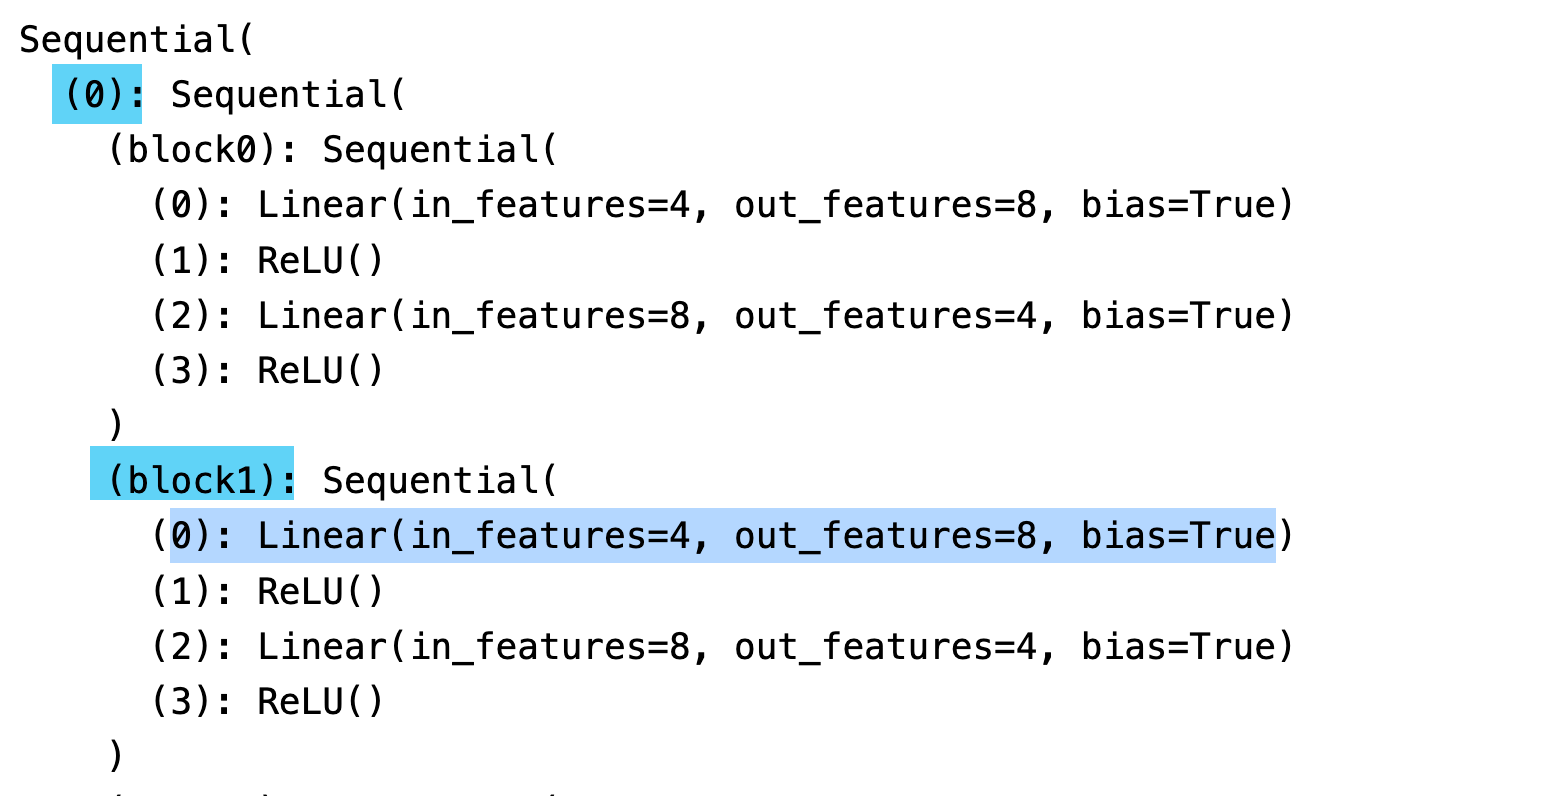

In [28]:
# 因为层是分层嵌套的，通过嵌套列表索引一样访问它们
# 访问第一个主要块中，第二个子块的第一层的偏置项
rgnet[0][1][0].bias.data

tensor([ 0.0450, -0.3545,  0.3777,  0.2296,  0.2797,  0.1127, -0.2106, -0.1567])

In [31]:
# 参数初始化 内置初始化
def init_normal(m):
    if type(m) == nn.Linear:#如果是线性层 则进行初始化
        nn.init.normal_(m.weight,mean=0,std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
print(net[0].weight.data)
print(net[0].bias.data)

print(net[0].weight.data[0])
print(net[0].bias.data[0])


tensor([[-0.0026, -0.0045, -0.0178,  0.0045],
        [ 0.0015, -0.0014, -0.0041, -0.0055],
        [ 0.0122, -0.0100,  0.0130,  0.0106],
        [ 0.0022,  0.0081, -0.0140, -0.0008],
        [-0.0015, -0.0149,  0.0042,  0.0121],
        [-0.0001, -0.0016, -0.0034,  0.0136],
        [-0.0066, -0.0122,  0.0234,  0.0092],
        [-0.0039, -0.0097,  0.0034, -0.0107]])
tensor([0., 0., 0., 0., 0., 0., 0., 0.])


In [32]:
# 所有参数初始化为常数1
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight,1)
        nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data,net[0].bias.data

(tensor([[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0.]))

In [34]:
# 对不同的块采用不同的初始化方法
# Xavier初始化方法初始化第一个神经网络
# 第三个神经网络层初始化为常量值42
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight,42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.6394, -0.2584, -0.4114,  0.1676])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


In [40]:
# 自定义初始化

def my_init(m):
    # 定义初始化函数 接受模块’m‘作为输入
    if type(m) == nn.Linear:
        # 检查模块’m‘是不是线性层，如果是线性层，则进行初始化操作
        print("Init",*[(name,param.shape)
                       for name,param in m.named_parameters()][0])
        # 打印初始化信息，输出线性层的参数名称和形状
        # 使用列表解析式和*操作符，打印参数信息的第一项
        nn.init.uniform_(m.weight,-10,10)
        # 使用均匀分布初始化线性层的权重，范围在-10到10之间
        m.weight.data *= m.weight.data.abs() >= 5
        # 将权重的数值限制在绝对值>= 5的范围内，
        # 这个操作的目的是将权值截断在一定范围内，确保不会过大或者过小

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[0.0000, 0.0000, 0.0000, -0.0000],
        [8.0034, 7.8001, 8.4589, 5.0673]], grad_fn=<SliceBackward0>)

### print("Init",*[(name,param.shape)
                       for name,param in m.named_parameters()][0])
\* 表示 拆包运算符 将列表中的元素解包为多个独立的参数

解释：
- [(name, param.shape) for name, param in m.named_parameters()]: 这部分生成了一个列表，其中每个元素都是一个元组 (name, param.shape)。

- [0]: 然后，通过 [0] 取得这个列表的第一个元素，即第一个参数的元组 (name, param.shape)。

* 最后，* 将这个元组中的两个元素 (name, param.shape) 拆包为两个独立的参数。

所以，* 的作用在于将列表中的元组拆包为多个参数，以便传递给 print 函数。这种用法通常在函数调用或其他需要将序列中的元素作为独立参数传递的场景中使用。

### m.weight.data *= m.weight.data.abs() >= 5

m.weight.data.abs() 计算权重张量’m.weight.data‘中每个元素的绝对值  
m.weight.data.abs() >= 5 创建布尔张量，判断对应位置原始权重张量绝对值是否大于等于5  
m.weight.data *= m.weight.data.abs() >= 5 将原始权重张量中绝对值大于等于5的元素保留，其余元素置0。

实现原理：将原始权重张量与上面的布尔张量进行逐元素相乘实现

将权重张量中绝对值小于 5 的元素设置为零。这样的操作通常被称为截断（clipping）或修剪（trimming）权重。这有助于防止权重过大，从而控制模型的复杂性，防止梯度爆炸等问题。

总结一下，这行代码的目的是截断权重，将绝对值小于 5 的权重设置为零。

In [37]:
net

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [38]:
# 直接设置参数
net[0].weight.data[:] +=1
net[0].weight.data[0,0] = 42
net[0].weight.data[0]

tensor([42.0000, -8.7091,  8.5059,  1.0000])

## 5.2.3 参数绑定


In [42]:
# 多个层间共享参数：定义稠密层，使用它的参数来设置另一个层的参数
# 给共享层设置一个名称，方便引用它的参数
shared = nn.Linear(8,8)
net = nn.Sequential(nn.Linear(4,8),
                    nn.ReLU(),
                    shared,
                    nn.ReLU(),
                    shared,
                    nn.ReLU(),
                    nn.Linear(8,1))
net(X)
# 检查参数是否相同
print(net[2].weight.data == net[4].weight.data)
net[2].weight.data[0,0] = 100
# 确保它们实际上是同一个对象，而不是只有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]])
tensor([True, True, True, True, True, True, True, True])


### 不带参数的层

In [55]:
import torch
import torch.nn.functional as F
from torch import nn

In [56]:
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X-X.mean()

layer = CenteredLayer()
layer(torch.FloatTensor([1,2,3,4,5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [57]:
# 将层作为组件合并到更复杂的模型中
net = nn.Sequential(
    nn.Linear(8,128),
    CenteredLayer()
)

---
### 补充nn.Parameter

- 特殊的张量类，用于表示神经网络中需要被优化的参数
-  torch.Tensor 的子类，但它会被自动注册为模型参数，从而在模型的参数列表中进行跟踪。
-  使用 nn.Parameter 类来创建模型的权重和偏置。


In [51]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.randn(10, 5))  # 举例创建一个权重参数

    def forward(self, x):
        return torch.matmul(x, self.weight)

# 创建模型
model = MyModel()

# 打印模型参数
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

weight: torch.Size([10, 5])


在上述示例中，
- **self.weight 是一个 nn.Parameter 实例，表示模型的权重。**
- nn.Parameter 对象会被自动注册到模型的参数列表中，可以**通过 named_parameters() 方法**访问。
-  PyTorch 中用于表示神经网络参数的特殊类型，它简化了参数的管理和优化过程。

---

In [58]:
'''-
健全性检查，在向网络发送随机数数据后，检查均值是否为0
由于处理的是浮点数，因为存储精度的原因，我们仍会看到一个非常小的数
'''
Y = net(torch.rand(4,8))
Y.mean()

tensor(-3.2596e-09, grad_fn=<MeanBackward0>)

In [59]:
# 带参数的层
class MyLinear(nn.Module):
    def __init__(self,in_units,units):
        super().__init__() #继承nn.Module的初始化方法
        self.weight = nn.Parameter(torch.randn(in_units,units))
        self.bias = nn.Parameter(torch.randn(units,))
    def forward(self,X):
        linear = torch.matmul(X,self.weight.data) + self.bias.data
        return F.relu(linear)


In [60]:
linear = MyLinear(5,3)
linear.weight

Parameter containing:
tensor([[-2.1530,  0.3343, -0.1225],
        [-1.2021, -0.0367, -2.3667],
        [-0.3315, -1.3647, -0.2884],
        [-0.2845, -1.5424, -0.2487],
        [ 0.6427, -1.5238,  0.6542]], requires_grad=True)

In [61]:
# 使用自定义层执行前向传播
linear(torch.rand(2,5))

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [62]:
# 使用我们自定义的层构建模型 就像使用内置的全连接层一样使用自定义层
net = nn.Sequential(MyLinear(64,8),
                    MyLinear(8,1))
net(torch.rand(2,64))

tensor([[ 0.0000],
        [10.9262]])

# 5.5读写文件

In [63]:
# 加载和保存张量
x = torch.arange(4)
torch.save(x,'x-file')

In [64]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

In [65]:
# 存储一个张量列表，读回内存
y = torch.zeros(4)
torch.save([x,y],'x-files')
x2,y2 = torch.load('x-files')
(x2,y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [66]:
mydict = {'x':x,'y':y}
torch.save(mydict,'mydict')
mydict2 = torch.load('mydict')
mydict2
# 写入或读取从字符串映射到张量的字典
# where;读取或写入模型的所有权重时

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

In [67]:
# 加载和保存模型参数
# 为了恢复模型，我们采取的做法
# ①用代码生成架构
# ②从磁盘加载参数
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20,256)
        self.output = nn.Linear(256,10)
        # 继承父类的初始化方法 self.hidden是nn.Linear的一个实例化
    def forward(self,x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2,20))  #normal distribution
Y = net(X)


In [68]:
# 存储模型参数 'mlp.params'文件中
torch.save(net.state_dict(),'mlp.params')

In [69]:
# 为恢复模型，实例化原始多层感知机的一个备份
# 不需要随机初始化模型参数 而是直接读取文件中存储的参数
clone = MLP()
# 创建一个 MLP 类的新实例 clone
clone.load_state_dict(torch.load('mlp.params'))
# 使用 load_state_dict 方法从文件 'mlp.params' 中加载预训练模型的参数到新创建的 clone 模型中。
#  torch.load 函数加载之前保存的模型参数文件 'mlp.params'。
# load_state_dict 方法将加载的参数字典加载到 clone 模型中，以使 clone 模型具有预训练模型的参数。
clone.eval()
# 将模型设置为评估模式，即调用 eval() 方法。
# 训练模式和评估模式的区别在于，有些模型层（例如，Dropout）在训练和评估时的行为是不同的。调用 eval() 方法会将模型切换到评估模式，以确保在进行推理时不会应用训练时的一些特殊操作，如 Dropout。
# 评估模式不会进行dropout操作

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [70]:
Y_clone = clone(X)
Y_clone == Y
# 两个实例具有相同的模型参数，在输入相同的X时，两个实例的计算结果也相同

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])